Polynomial Regression - you can use your data to build a linear or polynomial regression line.  Use this line to predict future values.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandas_profiling import ProfileReport
import math as ma

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

get_ipython().run_line_magic('matplotlib', 'inline')

In [12]:
def years_prior(df: pd.DataFrame, years = 0.0, inplace = False) -> pd.DataFrame:

    days = ma.floor(360 * years)
    index_to_drop = range(0, len(df.index) - days)

    if(index_to_drop[-1] > df.index[-1]):

        return df.drop(index = df.index, inplace = inplace)
        
    else:

        return df.drop(index = index_to_drop, inplace = inplace)


def weeks_prior(df: pd.DataFrame, weeks = 1) -> pd.DataFrame:

    days = ma.floor(7 * weeks)
    index_to_drop = range(0, len(df.index) - days)

    if(index_to_drop[-1] > df.index[-1]):

        return df.drop(index = df.index)
        
    else:

        return df.drop(index = index_to_drop)


def time_prior(df: pd.DataFrame, duration: float, time_unit: str) -> pd.DataFrame:

    interval_factor = { 'year': 360, 'quater': 90, 'month': 30, 'week': 7, 'day': 1 }

    if time_unit not in interval_factor:

        raise Exception('time_unit may only be "year", "quater", "month", or "day"')
        
    days = ma.floor(interval_factor[time_unit] * duration)
    index_to_drop = range(0, len(df.index) - days)

    if(index_to_drop[-1] > df.index[-1]):

        return df.drop(index = df.index)

    else:

        return df.drop(index = index_to_drop)


def polynomial_regression(x: np.array, y: np.array, degree: int) -> LinearRegression:

    '''
        Takes in two list: x and y, and returns a polynomial regression model based on the degree argument
    '''

    x = np.array(x)
    y = np.array(y)

    x = x[:, np.newaxis]
    y = y[:, np.newaxis]

    print(x)
    print(y)
    return
    
    x_poly = PolynomialFeatures(degree = degree).fit_transform(x, y = y)

    return LinearRegression().fit(x_poly, y)

    

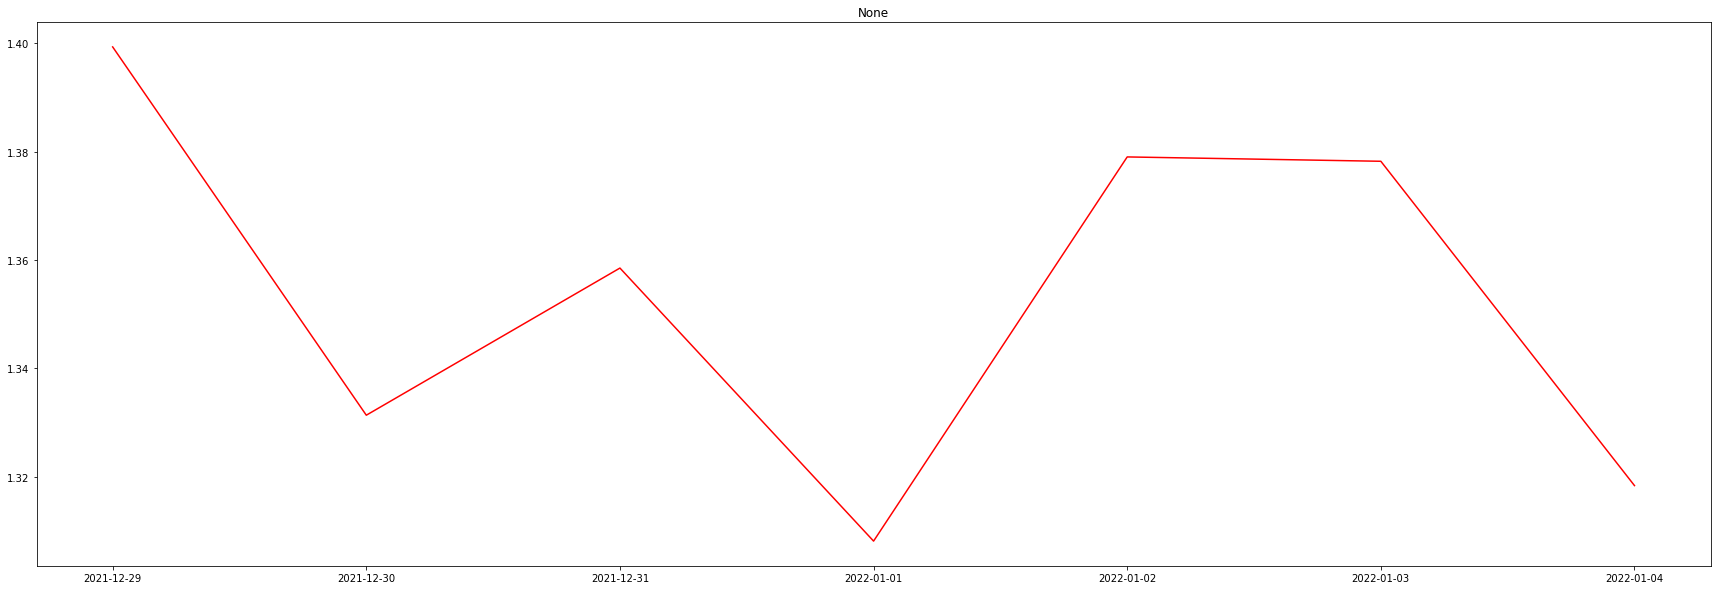

[['2021-12-29T00:00:00.000000000']
 ['2021-12-30T00:00:00.000000000']
 ['2021-12-31T00:00:00.000000000']
 ['2022-01-01T00:00:00.000000000']
 ['2022-01-02T00:00:00.000000000']
 ['2022-01-03T00:00:00.000000000']
 ['2022-01-04T00:00:00.000000000']]
[[1.3993  ]
 [1.331352]
 [1.3585  ]
 [1.308127]
 [1.379002]
 [1.3782  ]
 [1.318366]]


In [15]:
df_cardano  = pd.read_csv('../data/Cardano.csv',    parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])
df_ethereum = pd.read_csv('../data/Ethereum.csv',   parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])
df_solana   = pd.read_csv('../data/Solana.csv',     parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])
df_dogecoin = pd.read_csv('../data/Dogecoin.csv',   parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])

#df = pd.merge(pd.merge(df_cardano, df_ethereum, on = 'Date', how = "left", suffixes = ['_cardano', '_ether']), pd.merge(df_solana, df_dogecoin, on = 'Date', how = "left", suffixes = ['_solana', '_dogecoin']), on = 'Date', how = "left")


plt.figure(figsize = (30,10))
plt.grid(False)
plt.title('None')

df_cardano_week = time_prior(df_cardano, 7, 'day')
plt.plot(df_cardano_week['Date'], df_cardano_week['Closing Price (USD)'], label = 'None', color = 'red')
# plt.plot(df.Date, df['Closing Price (USD)'], label = 'None', color = 'blue')
# plt.plot(df_solana.Date, df_solana['Closing Price (USD)'], label = 'None', color = 'green')
# plt.plot(df_dogecoin.Date, df_dogecoin['Closing Price (USD)'], label = 'None', color = 'pink')

plt.show()

df_cardano_week = time_prior(df_cardano, 7, 'day')
model = polynomial_regression(df_cardano_week['Date'], df_cardano_week['Closing Price (USD)'], 2)

# y_poly_pred = model.predict(PolynomialFeatures(degree = 2).fit_transform(df_cardano_week['Closing Price (USD)']))

# plt.scatter(df_cardano_week['Date'], df_cardano_week['Closing Price (USD)'], s = 10)
# plt.plot(df_cardano_week['Date'], y_poly_pred, color = 'm')
# plt.show()